# Neural Network for Density Forecasting EC331

In [1]:
#######################################################################
#######################################################################
######################### Importing Packages ##########################
#######################################################################
#######################################################################

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import tensorflow as tf
import math
from datetime import datetime, timedelta
import scipy.stats

# need to clean these up later
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow_probability as tfp
import pandas as pd
from keras.models import Sequential
from tensorflow.keras import regularizers
from keras.layers import Activation, Input, Dense, LSTM, concatenate
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
tfd = tfp.distributions

from numpy.random import rand
from numpy import ix_
np.random.seed(1337)

# Data Importing and Pre-Processing

In [2]:
#######################################################################
#######################################################################
###################### Data Importing/Cleaning ########################
#######################################################################
#######################################################################

# import data and calculate log returns from adjusted close
df_Nikkei_RAW = pd.read_csv("C:/Warwick Final Year/RAE/Data/^N225.csv")
df_NASDAQ_RAW = pd.read_csv("C:/Warwick Final Year/RAE/Data/^IXIC.csv")
df_DAX_RAW = pd.read_csv("C:/Warwick Final Year/RAE/Data/^GDAXI.csv")

In [3]:
def Data_Processor(DATA,
                   Batch_Size,
                   Length_of_Batch,
                   Test_Train_Split):
    
    DATA.columns = [c.replace(' ', '_') for c in DATA.columns]
    DATA = DATA[DATA['Adj_Close'].notnull()]
    DATA['log_ret'] = np.log(DATA.Adj_Close) - np.log(DATA.Adj_Close.shift(1))

    # spilt to training and test sets
    DATA    = DATA[['Date','log_ret']][1:]
    DATA['Date'] = DATA['Date'].apply(pd.Timestamp)
    DATA.set_index('Date',inplace=True, drop=True)
    
    train = DATA.loc[:Test_Train_Split]
    test  = DATA.loc[Test_Train_Split:]
   
    DATA_train = [[i] for i in train['log_ret']]
    DATA_test  = [[i] for i in test['log_ret']]
    
    scaler = MinMaxScaler()
    scaler.fit(train)
    scaled_train = scaler.transform(train)
    scaled_test = scaler.transform(test)
    
    # creating time series generator for processing
    # make one for training, one for validation
    time_series_generator = TimeseriesGenerator(DATA_train, 
                                                DATA_train, 
                                                length=Length_of_Batch, 
                                                batch_size=Batch_Size)
    time_series_val_generator = TimeseriesGenerator(DATA_test,
                                                    DATA_test, 
                                                    length=Length_of_Batch, 
                                                    batch_size=Batch_Size)

    
    return {"Data" : DATA,
            "Training" : time_series_generator,
            "Validation" : time_series_val_generator}



In [4]:
Batch_Size = 64
Length     = 25
Test_Train_Split = '2015-01-01'

Nikkei = Data_Processor(df_Nikkei_RAW,
                       Batch_Size,
                       Length,
                       Test_Train_Split)
NASDAQ = Data_Processor(df_NASDAQ_RAW,
                       Batch_Size,
                       Length,
                       Test_Train_Split)
DAX = Data_Processor(df_DAX_RAW,
                       Batch_Size,
                       Length,
                       Test_Train_Split)

<ipython-input-3-2335be0e7533>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATA['log_ret'] = np.log(DATA.Adj_Close) - np.log(DATA.Adj_Close.shift(1))
<ipython-input-3-2335be0e7533>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATA['log_ret'] = np.log(DATA.Adj_Close) - np.log(DATA.Adj_Close.shift(1))


# Plotting Stock Returns

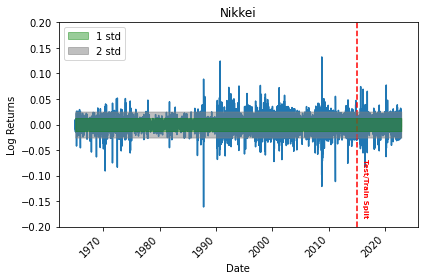

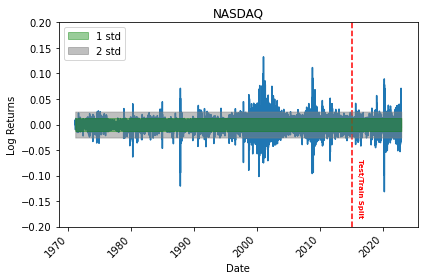

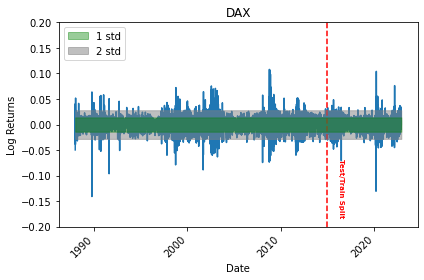

In [6]:
for count,i in enumerate([Nikkei['Data'],
         NASDAQ['Data'],
         DAX['Data']]):
    

    if count == 0:
        NAME = "Nikkei"
    elif count == 1:
        NAME = "NASDAQ"
    else:
        NAME = "DAX"
    
    ax = i.plot(y='log_ret', 
            kind='line',
            rot=45,
            legend=False,
            title=NAME
           )
    
    
    means = np.repeat(0,len(i['log_ret']))
    std   = np.repeat(np.std(i['log_ret']),len(i['log_ret']))
    x     = pd.date_range(str(i.index.values[0]), str(i.index.values[-1]),freq="D")
    ax.axvline(pd.to_datetime('2015-01-01'),color='r',linestyle='--')
    s1 = ax.fill_between(i.index.values, np.add(means,std),np.subtract(means,std), color='green',zorder=4,alpha=0.4)
    s2 = ax.fill_between(i.index.values, np.add(means,np.multiply(2,std)),
                     np.subtract(means,np.multiply(2,std)), 
                     color='grey',
                     zorder=3,
                     alpha=0.5)
    ax.text(pd.to_datetime('2016-06-01'), 
            -0.18,
        "Test/Train Split",
        horizontalalignment='center', 
            fontweight='bold', 
            color='red', 
            rotation=-90,
           fontsize='x-small')
    
    years = mdates.YearLocator(10)   # every year
    years_fmt = mdates.DateFormatter('%Y')
    
    
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.set(ylabel = "Log Returns")
    ax.legend(handles=[s1,s2], labels=["1 std","2 std"],loc='upper left')
    ax.set_ylim([-0.2, 0.2])
    plt.tight_layout() 
    ax.figure.savefig('C:/Warwick Final Year/RAE/Graphs/' + str(count) + 'logret.pdf')

# The Neural Network Architecture

These neural network models work by assuming some parametrised distribution for the stock returns and forecasting the parameters of the distribution in the following period. 
\
As a loss function we use the log of the probability density function. Thus, our neural network is in effect being trained to converge to the maximum likelihood estimators. 
\
Basic building block is LSTM layers interspersed with dropout layers for regularisation.

In [12]:
"""

# 100-70-50 with 0.7,0.6,0.5 works okay (not good but okay)
# 30-50-30 with 0.7,0.6,0.5 also good

# BEST SO FAR dual channels 20-50-20 LSTM with 0.4-0.6-0.3 dropout, length of seq = 25

# better performance from parallel models for mean and variance 
# doesn't seem to work well when outputting both from single LSTM --> features of mean and std are different!
# however, seems to be having trouble fitting the mean and the std at the same time
# sets the conditional mean to be constant then varies the std --> getting caught in a local minimum
# maybe need to try changing the initialisation?
"""

class Model(tf.keras.Model):
    
    def __init__(self, distribution):
        super().__init__()
        
        self.distribution = distribution
        
        # conditional mean channel
        self.LSTM1 = tf.keras.layers.LSTM(8, 
                                          activation=tf.nn.relu,
                                          return_sequences=True)
        
        self.LSTM2 = tf.keras.layers.LSTM(16, 
                                          activation=tf.nn.relu,
                                          return_sequences=True)
        
        self.LSTM3 = tf.keras.layers.LSTM(8, 
                                          activation=tf.nn.relu,
                                          return_sequences=False)
        
        
        # scale/std channel 
        self.LSTM4 = tf.keras.layers.LSTM(8, 
                                          activation=tf.nn.relu,
                                          return_sequences=True)
        
        self.LSTM5 = tf.keras.layers.LSTM(16, 
                                          activation=tf.nn.relu,
                                          return_sequences=True)
        
        
        self.LSTM6 = tf.keras.layers.LSTM(8, 
                                          activation=tf.nn.relu,
                                          return_sequences=False)
        
        # DoF Channel
        
        self.LSTM7 = tf.keras.layers.LSTM(8, 
                                          activation=tf.nn.relu,
                                          return_sequences=True)
        
        self.LSTM8 = tf.keras.layers.LSTM(16, 
                                          activation=tf.nn.relu,
                                          return_sequences=True)
        
        
        self.LSTM9 = tf.keras.layers.LSTM(8, 
                                          activation=tf.nn.relu,
                                          return_sequences=False)


        # dropout layers to regularise
        self.dropout1 = tf.keras.layers.Dropout(0.3)
        self.dropout2 = tf.keras.layers.Dropout(0.4)
        self.dropout3 = tf.keras.layers.Dropout(0.3)
        
        self.dropout4 = tf.keras.layers.Dropout(0.3)
        self.dropout5 = tf.keras.layers.Dropout(0.4)
        self.dropout6 = tf.keras.layers.Dropout(0.3)
        
        self.dropout7 = tf.keras.layers.Dropout(0.3)
        self.dropout8 = tf.keras.layers.Dropout(0.4)
        self.dropout9 = tf.keras.layers.Dropout(0.3)



        # a dense layer for conditional mean
        self.dense1 = tf.keras.layers.Dense(1, 
                                            activation='sigmoid')
        # create a function to scale the sigmoid function to take values between 0 and 1/2 since a random
        # variable taking values in [0,1] has std between these values (Popovinciu's Inequality)
        self.dense2 = tf.keras.layers.Dense(1, 
                                            lambda x: tf.keras.activations.sigmoid(x)*0.5)
        
        # for t-distribution the scale parameter doesn't correspond to std 
        # DoF >0 and scale >0 so use relu for these
        
        self.dense3 = tf.keras.layers.Dense(1,
                                           activation='relu')
        
        self.dense4 = tf.keras.layers.Dense(1,
                                           activation='relu')
        
    

    def call(self, inputs):
        # LSTM --> Dropout --> dense with 2 outputs (conditional mean & std)
        
        if self.distribution in ['Normal',"Laplace"] :
            # mean channel
            x1 = self.LSTM1(inputs)
            x1 = self.dropout1(x1)    
            x1 = self.LSTM2(x1)
            x1 = self.dropout2(x1)
            x1 = self.LSTM3(x1)
            x1 = self.dropout3(x1)

            # std channel
            x2 = self.LSTM4(inputs)
            x2 = self.dropout4(x2)
            x2 = self.LSTM5(x2)
            x2 = self.dropout5(x2)
            x2 = self.LSTM6(x2)
            x2 = self.dropout6(x2)

            out1 = self.dense1(x1)
            out2 = self.dense2(x2)

            return concatenate([out1,out2])
        
        elif self.distribution == 't':
            
             # mean channel
            x1 = self.LSTM1(inputs)
            x1 = self.dropout1(x1)    
            x1 = self.LSTM2(x1)
            x1 = self.dropout2(x1)
            x1 = self.LSTM3(x1)
            x1 = self.dropout3(x1)

            # scale channel
            x2 = self.LSTM4(inputs)
            x2 = self.dropout4(x2)
            x2 = self.LSTM5(x2)
            x2 = self.dropout5(x2)
            x2 = self.LSTM6(x2)
            x2 = self.dropout6(x2)
            
            # DoF channel for t dist
            
            x3 = self.LSTM7(inputs)
            x3 = self.dropout7(x3)
            x3 = self.LSTM8(x3)
            x3 = self.dropout8(x3)
            x3 = self.LSTM9(x3)
            x3 = self.dropout9(x3)

            out1 = self.dense1(x1)
            out2 = self.dense3(x2)
            out3 = self.dense4(x3)

            return concatenate([out1,out2,out3])
            
    


In [13]:
def loss_func(distribution):
    if distribution == "Normal":
        def loss_comp(y_true, y_pred):
            (mean_pred, scale_pred) = tf.split(y_pred, num_or_size_splits=2, axis=1)
            dist = tfd.Normal(loc = mean_pred, scale=tf.math.add(scale_pred,1e-10))   
            log_dens = tf.math.log(tf.math.add(dist.prob(y_true),1e-10))
            loss = -tf.math.reduce_mean(log_dens)
            return loss
            
    elif distribution == "t":
        def loss_comp(y_true, y_pred):
            (mean_pred, scale_pred, nu_pred) = tf.split(y_pred, num_or_size_splits=3, axis=1)
            dist = tfd.StudentT(df = tf.math.add(nu_pred,1e-10), loc = mean_pred, scale=tf.math.add(scale_pred,1e-10))   
            log_dens = tf.math.log(dist.prob(y_true))
            loss = -tf.math.reduce_mean(log_dens)
            
            return loss
        
    elif distribution == "Laplace":
        # in the dense output we use Popovinciu's inequality to get a bound on the 
        # variance / std. However, we the Laplacian variance is 2b^2 where b is the scale 
        # parameter. For our inequality to be valid we then 
        def loss_comp(y_true, y_pred):
            (mean_pred, scale_pred) = tf.split(y_pred, num_or_size_splits=2, axis=1)
            dist = tfd.Laplace(loc = mean_pred, 
                               scale=tf.math.add(tf.math.sqrt(tf.math.divide(scale_pred,2)),1e-10))   
            log_dens = tf.math.log(tf.math.add(dist.prob(y_true),1e-10))
            loss = -tf.math.reduce_mean(log_dens)
            return loss
        
    return loss_comp
                     

In [14]:
# create callbacks

# currently using loss on training set to avoid any fitting to test set,
# also just want to see if we can model the data well in any case, even with overfitting

path_checkpoint = "C:/Warwick Final Year/RAE/Code Python/Model Checkpoints"

callbacks = {}
for i in ["Normal","t","Laplace"]:

    callbacks[i] = [ ModelCheckpoint(filepath=path_checkpoint + "/" + i,
                                         monitor='loss',
                                         verbose=1,
                                         save_weights_only=True,
                                         save_best_only=True),
                    ReduceLROnPlateau(monitor='loss',
                                              factor=0.1,
                                              min_lr=1e-10,
                                              patience=50,
                                              verbose=1)]



# Training the Models

In [15]:
# Pick which series to fit:
time_series_generator = Nikkei['Training']
time_series_val_generator = Nikkei['Validation']

In [16]:
# first we fit the model using a t-distribution
model_t = Model("t")

loss_computer_t = loss_func("t")
# setting seed as stochastic intialisation
tf.random.set_seed(
    102
)

model_t.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=loss_computer_t)

epochs = 2000

t_History = model_t.fit(time_series_generator,        
                        epochs = epochs, 
                        shuffle = False,
                        validation_data=time_series_val_generator,
                        callbacks=callbacks["t"])
             

Epoch 1/2000
191/192 [============================>.] - ETA: 0s - loss: 5.1649
Epoch 1: loss improved from inf to 5.16058, saving model to C:/Warwick Final Year/RAE/Code Python/Model Checkpoints\t
192/192 [==============================] - 22s 48ms/step - loss: 5.1606 - val_loss: 4.1170 - lr: 1.0000e-04
Epoch 2/2000
192/192 [==============================] - ETA: 0s - loss: 1.7076
Epoch 2: loss improved from 5.16058 to 1.70755, saving model to C:/Warwick Final Year/RAE/Code Python/Model Checkpoints\t
192/192 [==============================] - 9s 45ms/step - loss: 1.7076 - val_loss: -1.4088 - lr: 1.0000e-04
Epoch 3/2000
192/192 [==============================] - ETA: 0s - loss: -1.4702
Epoch 3: loss improved from 1.70755 to -1.47019, saving model to C:/Warwick Final Year/RAE/Code Python/Model Checkpoints\t
192/192 [==============================] - 8s 43ms/step - loss: -1.4702 - val_loss: -2.7842 - lr: 1.0000e-04
Epoch 4/2000
191/192 [============================>.] - ETA: 0s - loss: -2

Epoch 31/2000
192/192 [==============================] - ETA: 0s - loss: -2.2603
Epoch 31: loss did not improve from -2.29004
192/192 [==============================] - 9s 49ms/step - loss: -2.2603 - val_loss: -2.8886 - lr: 1.0000e-04
Epoch 32/2000
191/192 [============================>.] - ETA: 0s - loss: -2.2475
Epoch 32: loss did not improve from -2.29004
192/192 [==============================] - 10s 52ms/step - loss: -2.2470 - val_loss: -2.8784 - lr: 1.0000e-04
Epoch 33/2000
191/192 [============================>.] - ETA: 0s - loss: -2.2744
Epoch 33: loss did not improve from -2.29004
192/192 [==============================] - 10s 50ms/step - loss: -2.2741 - val_loss: -2.8851 - lr: 1.0000e-04
Epoch 34/2000
191/192 [============================>.] - ETA: 0s - loss: -2.3002
Epoch 34: loss improved from -2.29004 to -2.29957, saving model to C:/Warwick Final Year/RAE/Code Python/Model Checkpoints\t
192/192 [==============================] - 10s 50ms/step - loss: -2.2996 - val_loss: -2

192/192 [==============================] - 11s 57ms/step - loss: -2.4041 - val_loss: -2.9399 - lr: 1.0000e-04
Epoch 63/2000
192/192 [==============================] - ETA: 0s - loss: -2.3574
Epoch 63: loss did not improve from -2.40413
192/192 [==============================] - 11s 57ms/step - loss: -2.3574 - val_loss: -2.9113 - lr: 1.0000e-04
Epoch 64/2000
192/192 [==============================] - ETA: 0s - loss: -2.4112
Epoch 64: loss improved from -2.40413 to -2.41115, saving model to C:/Warwick Final Year/RAE/Code Python/Model Checkpoints\t
192/192 [==============================] - 10s 52ms/step - loss: -2.4112 - val_loss: -2.9626 - lr: 1.0000e-04
Epoch 65/2000
192/192 [==============================] - ETA: 0s - loss: -2.3936
Epoch 65: loss did not improve from -2.41115
192/192 [==============================] - 10s 49ms/step - loss: -2.3936 - val_loss: -2.9480 - lr: 1.0000e-04
Epoch 66/2000
192/192 [==============================] - ETA: 0s - loss: -2.4006
Epoch 66: loss did no

Epoch 94/2000
192/192 [==============================] - ETA: 0s - loss: -2.4909
Epoch 94: loss did not improve from -2.52354
192/192 [==============================] - 11s 60ms/step - loss: -2.4909 - val_loss: -2.9439 - lr: 1.0000e-04
Epoch 95/2000
192/192 [==============================] - ETA: 0s - loss: -2.5087
Epoch 95: loss did not improve from -2.52354
192/192 [==============================] - 10s 50ms/step - loss: -2.5087 - val_loss: -2.9563 - lr: 1.0000e-04
Epoch 96/2000
192/192 [==============================] - ETA: 0s - loss: -2.4980
Epoch 96: loss did not improve from -2.52354
192/192 [==============================] - 11s 57ms/step - loss: -2.4980 - val_loss: -2.9451 - lr: 1.0000e-04
Epoch 97/2000
191/192 [============================>.] - ETA: 0s - loss: -2.4945
Epoch 97: loss did not improve from -2.52354
192/192 [==============================] - 10s 51ms/step - loss: -2.4932 - val_loss: -2.9427 - lr: 1.0000e-04
Epoch 98/2000
192/192 [==============================] -

192/192 [==============================] - 13s 66ms/step - loss: -2.7180 - val_loss: -3.0067 - lr: 1.0000e-04
Epoch 158/2000
191/192 [============================>.] - ETA: 0s - loss: -2.7248
Epoch 158: loss improved from -2.71802 to -2.72237, saving model to C:/Warwick Final Year/RAE/Code Python/Model Checkpoints\t
192/192 [==============================] - 10s 50ms/step - loss: -2.7224 - val_loss: -2.9825 - lr: 1.0000e-04
Epoch 159/2000
192/192 [==============================] - ETA: 0s - loss: -2.7110
Epoch 159: loss did not improve from -2.72237
192/192 [==============================] - 9s 47ms/step - loss: -2.7110 - val_loss: -3.0039 - lr: 1.0000e-04
Epoch 160/2000
191/192 [============================>.] - ETA: 0s - loss: -2.7442
Epoch 160: loss improved from -2.72237 to -2.74263, saving model to C:/Warwick Final Year/RAE/Code Python/Model Checkpoints\t
192/192 [==============================] - 10s 50ms/step - loss: -2.7426 - val_loss: -2.9928 - lr: 1.0000e-04
Epoch 161/2000
19

Epoch 187/2000
191/192 [============================>.] - ETA: 0s - loss: -2.8508
Epoch 187: loss improved from -2.84468 to -2.84927, saving model to C:/Warwick Final Year/RAE/Code Python/Model Checkpoints\t
192/192 [==============================] - 9s 49ms/step - loss: -2.8493 - val_loss: -3.0345 - lr: 1.0000e-04
Epoch 188/2000
191/192 [============================>.] - ETA: 0s - loss: -2.8496
Epoch 188: loss did not improve from -2.84927
192/192 [==============================] - 9s 47ms/step - loss: -2.8483 - val_loss: -3.0377 - lr: 1.0000e-04
Epoch 189/2000
191/192 [============================>.] - ETA: 0s - loss: -2.8579
Epoch 189: loss improved from -2.84927 to -2.85671, saving model to C:/Warwick Final Year/RAE/Code Python/Model Checkpoints\t
192/192 [==============================] - 9s 49ms/step - loss: -2.8567 - val_loss: -3.0346 - lr: 1.0000e-04
Epoch 190/2000
192/192 [==============================] - ETA: 0s - loss: -2.8583
Epoch 190: loss improved from -2.85671 to -2.85

192/192 [==============================] - 10s 50ms/step - loss: -3.0528 - val_loss: -3.0671 - lr: 1.0000e-04
Epoch 245/2000
191/192 [============================>.] - ETA: 0s - loss: -3.0585
Epoch 245: loss improved from -3.05279 to -3.05707, saving model to C:/Warwick Final Year/RAE/Code Python/Model Checkpoints\t
192/192 [==============================] - 10s 51ms/step - loss: -3.0571 - val_loss: -3.0601 - lr: 1.0000e-04
Epoch 246/2000
192/192 [==============================] - ETA: 0s - loss: -3.0622
Epoch 246: loss improved from -3.05707 to -3.06224, saving model to C:/Warwick Final Year/RAE/Code Python/Model Checkpoints\t
192/192 [==============================] - 9s 49ms/step - loss: -3.0622 - val_loss: -3.0683 - lr: 1.0000e-04
Epoch 247/2000
191/192 [============================>.] - ETA: 0s - loss: -3.0606
Epoch 247: loss did not improve from -3.06224
192/192 [==============================] - 9s 48ms/step - loss: -3.0592 - val_loss: -3.0630 - lr: 1.0000e-04
Epoch 248/2000
192

Epoch 274/2000
192/192 [==============================] - ETA: 0s - loss: -3.1059
Epoch 274: loss improved from -3.10320 to -3.10586, saving model to C:/Warwick Final Year/RAE/Code Python/Model Checkpoints\t
192/192 [==============================] - 12s 65ms/step - loss: -3.1059 - val_loss: -3.0734 - lr: 1.0000e-04
Epoch 275/2000
192/192 [==============================] - ETA: 0s - loss: -3.1058
Epoch 275: loss did not improve from -3.10586
192/192 [==============================] - 12s 64ms/step - loss: -3.1058 - val_loss: -3.0745 - lr: 1.0000e-04
Epoch 276/2000
192/192 [==============================] - ETA: 0s - loss: -3.1070
Epoch 276: loss improved from -3.10586 to -3.10696, saving model to C:/Warwick Final Year/RAE/Code Python/Model Checkpoints\t
192/192 [==============================] - 12s 63ms/step - loss: -3.1070 - val_loss: -3.0709 - lr: 1.0000e-04
Epoch 277/2000
192/192 [==============================] - ETA: 0s - loss: -3.1101
Epoch 277: loss improved from -3.10696 to -3

192/192 [==============================] - 9s 49ms/step - loss: -3.1351 - val_loss: -3.0779 - lr: 1.0000e-04
Epoch 305/2000
191/192 [============================>.] - ETA: 0s - loss: -3.1319
Epoch 305: loss did not improve from -3.13506
192/192 [==============================] - 9s 48ms/step - loss: -3.1299 - val_loss: -3.0765 - lr: 1.0000e-04
Epoch 306/2000
192/192 [==============================] - ETA: 0s - loss: -3.1340
Epoch 306: loss did not improve from -3.13506
192/192 [==============================] - 9s 49ms/step - loss: -3.1340 - val_loss: -3.0779 - lr: 1.0000e-04
Epoch 307/2000
191/192 [============================>.] - ETA: 0s - loss: -3.1351
Epoch 307: loss did not improve from -3.13506
192/192 [==============================] - 9s 48ms/step - loss: -3.1335 - val_loss: -3.0780 - lr: 1.0000e-04
Epoch 308/2000
191/192 [============================>.] - ETA: 0s - loss: -3.1356
Epoch 308: loss did not improve from -3.13506
192/192 [==============================] - 9s 48ms/s

Epoch 337/2000
192/192 [==============================] - ETA: 0s - loss: -3.1456
Epoch 337: loss improved from -3.14537 to -3.14557, saving model to C:/Warwick Final Year/RAE/Code Python/Model Checkpoints\t
192/192 [==============================] - 11s 58ms/step - loss: -3.1456 - val_loss: -3.0793 - lr: 1.0000e-04
Epoch 338/2000
192/192 [==============================] - ETA: 0s - loss: -3.1447
Epoch 338: loss did not improve from -3.14557
192/192 [==============================] - 10s 52ms/step - loss: -3.1447 - val_loss: -3.0788 - lr: 1.0000e-04
Epoch 339/2000
192/192 [==============================] - ETA: 0s - loss: -3.1420
Epoch 339: loss did not improve from -3.14557
192/192 [==============================] - 10s 51ms/step - loss: -3.1420 - val_loss: -3.0805 - lr: 1.0000e-04
Epoch 340/2000
192/192 [==============================] - ETA: 0s - loss: -3.1445
Epoch 340: loss did not improve from -3.14557
192/192 [==============================] - 10s 54ms/step - loss: -3.1445 - val

Epoch 369/2000
191/192 [============================>.] - ETA: 0s - loss: -3.1515
Epoch 369: loss did not improve from -3.15160
192/192 [==============================] - 8s 44ms/step - loss: -3.1496 - val_loss: -3.0801 - lr: 1.0000e-04
Epoch 370/2000
192/192 [==============================] - ETA: 0s - loss: -3.1484
Epoch 370: loss did not improve from -3.15160
192/192 [==============================] - 8s 43ms/step - loss: -3.1484 - val_loss: -3.0818 - lr: 1.0000e-04
Epoch 371/2000
192/192 [==============================] - ETA: 0s - loss: -3.1500
Epoch 371: loss did not improve from -3.15160
192/192 [==============================] - 9s 45ms/step - loss: -3.1500 - val_loss: -3.0808 - lr: 1.0000e-04
Epoch 372/2000
192/192 [==============================] - ETA: 0s - loss: -3.1490
Epoch 372: loss did not improve from -3.15160
192/192 [==============================] - 8s 44ms/step - loss: -3.1490 - val_loss: -3.0823 - lr: 1.0000e-04
Epoch 373/2000
191/192 [============================

Epoch 437/2000
191/192 [============================>.] - ETA: 0s - loss: -3.1584
Epoch 437: loss did not improve from -3.15889
192/192 [==============================] - 11s 55ms/step - loss: -3.1567 - val_loss: -3.0829 - lr: 1.0000e-04
Epoch 438/2000
192/192 [==============================] - ETA: 0s - loss: -3.1534
Epoch 438: loss did not improve from -3.15889
192/192 [==============================] - 12s 62ms/step - loss: -3.1534 - val_loss: -3.0816 - lr: 1.0000e-04
Epoch 439/2000
192/192 [==============================] - ETA: 0s - loss: -3.1541
Epoch 439: loss did not improve from -3.15889
192/192 [==============================] - 10s 52ms/step - loss: -3.1541 - val_loss: -3.0818 - lr: 1.0000e-04
Epoch 440/2000
191/192 [============================>.] - ETA: 0s - loss: -3.1561
Epoch 440: loss did not improve from -3.15889
192/192 [==============================] - 9s 49ms/step - loss: -3.1542 - val_loss: -3.0822 - lr: 1.0000e-04
Epoch 441/2000
192/192 [=========================

192/192 [==============================] - 8s 44ms/step - loss: -3.1558 - val_loss: -3.0844 - lr: 1.0000e-05
Epoch 506/2000
191/192 [============================>.] - ETA: 0s - loss: -3.1553
Epoch 506: loss did not improve from -3.15889
192/192 [==============================] - 8s 43ms/step - loss: -3.1534 - val_loss: -3.0843 - lr: 1.0000e-05
Epoch 507/2000
192/192 [==============================] - ETA: 0s - loss: -3.1562
Epoch 507: loss did not improve from -3.15889
192/192 [==============================] - 8s 44ms/step - loss: -3.1562 - val_loss: -3.0837 - lr: 1.0000e-05
Epoch 508/2000
191/192 [============================>.] - ETA: 0s - loss: -3.1553
Epoch 508: loss did not improve from -3.15889
192/192 [==============================] - 8s 42ms/step - loss: -3.1528 - val_loss: -3.0843 - lr: 1.0000e-05
Epoch 509/2000
192/192 [==============================] - ETA: 0s - loss: -3.1549
Epoch 509: loss did not improve from -3.15889
192/192 [==============================] - 8s 44ms/s

Epoch 540/2000
192/192 [==============================] - ETA: 0s - loss: -3.1556
Epoch 540: loss did not improve from -3.15889
192/192 [==============================] - 10s 50ms/step - loss: -3.1556 - val_loss: -3.0777 - lr: 1.0000e-06
Epoch 541/2000
191/192 [============================>.] - ETA: 0s - loss: -3.1559
Epoch 541: loss did not improve from -3.15889
192/192 [==============================] - 10s 50ms/step - loss: -3.1539 - val_loss: -3.0776 - lr: 1.0000e-06
Epoch 542/2000
192/192 [==============================] - ETA: 0s - loss: -3.1553
Epoch 542: loss did not improve from -3.15889
192/192 [==============================] - 10s 50ms/step - loss: -3.1553 - val_loss: -3.0775 - lr: 1.0000e-06
Epoch 543/2000
192/192 [==============================] - ETA: 0s - loss: -3.1539
Epoch 543: loss did not improve from -3.15889
192/192 [==============================] - 10s 51ms/step - loss: -3.1539 - val_loss: -3.0775 - lr: 1.0000e-06
Epoch 544/2000
191/192 [========================

Epoch 574/2000
192/192 [==============================] - ETA: 0s - loss: -3.1533
Epoch 574: loss did not improve from -3.15928
192/192 [==============================] - 10s 53ms/step - loss: -3.1533 - val_loss: -3.0776 - lr: 1.0000e-06
Epoch 575/2000
192/192 [==============================] - ETA: 0s - loss: -3.1531
Epoch 575: loss did not improve from -3.15928
192/192 [==============================] - 10s 50ms/step - loss: -3.1531 - val_loss: -3.0774 - lr: 1.0000e-06
Epoch 576/2000
192/192 [==============================] - ETA: 0s - loss: -3.1552
Epoch 576: loss did not improve from -3.15928
192/192 [==============================] - 9s 48ms/step - loss: -3.1552 - val_loss: -3.0774 - lr: 1.0000e-06
Epoch 577/2000
192/192 [==============================] - ETA: 0s - loss: -3.1549
Epoch 577: loss did not improve from -3.15928
192/192 [==============================] - 10s 50ms/step - loss: -3.1549 - val_loss: -3.0774 - lr: 1.0000e-06
Epoch 578/2000
192/192 [=========================

192/192 [==============================] - 10s 51ms/step - loss: -3.1561 - val_loss: -3.0771 - lr: 1.0000e-06
Epoch 609/2000
192/192 [==============================] - ETA: 0s - loss: -3.1604
Epoch 609: loss improved from -3.15928 to -3.16041, saving model to C:/Warwick Final Year/RAE/Code Python/Model Checkpoints\t
192/192 [==============================] - 10s 50ms/step - loss: -3.1604 - val_loss: -3.0769 - lr: 1.0000e-06
Epoch 610/2000
192/192 [==============================] - ETA: 0s - loss: -3.1521
Epoch 610: loss did not improve from -3.16041
192/192 [==============================] - 9s 48ms/step - loss: -3.1521 - val_loss: -3.0770 - lr: 1.0000e-06
Epoch 611/2000
192/192 [==============================] - ETA: 0s - loss: -3.1528
Epoch 611: loss did not improve from -3.16041
192/192 [==============================] - 9s 48ms/step - loss: -3.1528 - val_loss: -3.0769 - lr: 1.0000e-06
Epoch 612/2000
192/192 [==============================] - ETA: 0s - loss: -3.1554
Epoch 612: loss 

Epoch 643/2000
192/192 [==============================] - ETA: 0s - loss: -3.1576
Epoch 643: loss did not improve from -3.16041
192/192 [==============================] - 15s 78ms/step - loss: -3.1576 - val_loss: -3.0772 - lr: 1.0000e-06
Epoch 644/2000
192/192 [==============================] - ETA: 0s - loss: -3.1558
Epoch 644: loss did not improve from -3.16041
192/192 [==============================] - 15s 78ms/step - loss: -3.1558 - val_loss: -3.0773 - lr: 1.0000e-06
Epoch 645/2000
192/192 [==============================] - ETA: 0s - loss: -3.1527
Epoch 645: loss did not improve from -3.16041
192/192 [==============================] - 15s 78ms/step - loss: -3.1527 - val_loss: -3.0774 - lr: 1.0000e-06
Epoch 646/2000
192/192 [==============================] - ETA: 0s - loss: -3.1577
Epoch 646: loss did not improve from -3.16041
192/192 [==============================] - 15s 77ms/step - loss: -3.1577 - val_loss: -3.0774 - lr: 1.0000e-06
Epoch 647/2000
192/192 [========================

192/192 [==============================] - ETA: 0s - loss: -3.1563
Epoch 711: loss did not improve from -3.16041
192/192 [==============================] - 15s 77ms/step - loss: -3.1563 - val_loss: -3.0764 - lr: 1.0000e-08
Epoch 712/2000
192/192 [==============================] - ETA: 0s - loss: -3.1543
Epoch 712: loss did not improve from -3.16041
192/192 [==============================] - 15s 78ms/step - loss: -3.1543 - val_loss: -3.0764 - lr: 1.0000e-08
Epoch 713/2000
192/192 [==============================] - ETA: 0s - loss: -3.1568
Epoch 713: loss did not improve from -3.16041
192/192 [==============================] - 15s 78ms/step - loss: -3.1568 - val_loss: -3.0764 - lr: 1.0000e-08
Epoch 714/2000
192/192 [==============================] - ETA: 0s - loss: -3.1523
Epoch 714: loss did not improve from -3.16041
192/192 [==============================] - 15s 77ms/step - loss: -3.1523 - val_loss: -3.0764 - lr: 1.0000e-08
Epoch 715/2000
192/192 [==============================] - ETA: 

192/192 [==============================] - 14s 74ms/step - loss: -3.1581 - val_loss: -3.0764 - lr: 1.0000e-08
Epoch 746/2000
192/192 [==============================] - ETA: 0s - loss: -3.1525
Epoch 746: loss did not improve from -3.16041
192/192 [==============================] - 15s 77ms/step - loss: -3.1525 - val_loss: -3.0764 - lr: 1.0000e-08
Epoch 747/2000
192/192 [==============================] - ETA: 0s - loss: -3.1579
Epoch 747: loss did not improve from -3.16041
192/192 [==============================] - 15s 77ms/step - loss: -3.1579 - val_loss: -3.0764 - lr: 1.0000e-08
Epoch 748/2000
192/192 [==============================] - ETA: 0s - loss: -3.1594
Epoch 748: loss did not improve from -3.16041
192/192 [==============================] - 15s 78ms/step - loss: -3.1594 - val_loss: -3.0764 - lr: 1.0000e-08
Epoch 749/2000
192/192 [==============================] - ETA: 0s - loss: -3.1551
Epoch 749: loss did not improve from -3.16041
192/192 [==============================] - 15s 7

Epoch 780/2000
192/192 [==============================] - ETA: 0s - loss: -3.1558
Epoch 780: loss did not improve from -3.16041
192/192 [==============================] - 15s 78ms/step - loss: -3.1558 - val_loss: -3.0764 - lr: 1.0000e-09
Epoch 781/2000
192/192 [==============================] - ETA: 0s - loss: -3.1574
Epoch 781: loss did not improve from -3.16041
192/192 [==============================] - 15s 78ms/step - loss: -3.1574 - val_loss: -3.0764 - lr: 1.0000e-09
Epoch 782/2000
192/192 [==============================] - ETA: 0s - loss: -3.1553
Epoch 782: loss did not improve from -3.16041
192/192 [==============================] - 15s 77ms/step - loss: -3.1553 - val_loss: -3.0764 - lr: 1.0000e-09
Epoch 783/2000
192/192 [==============================] - ETA: 0s - loss: -3.1518
Epoch 783: loss did not improve from -3.16041
192/192 [==============================] - 15s 78ms/step - loss: -3.1518 - val_loss: -3.0764 - lr: 1.0000e-09
Epoch 784/2000
192/192 [========================

192/192 [==============================] - 15s 77ms/step - loss: -3.1561 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 849/2000
192/192 [==============================] - ETA: 0s - loss: -3.1572
Epoch 849: loss did not improve from -3.16041
192/192 [==============================] - 15s 78ms/step - loss: -3.1572 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 850/2000
192/192 [==============================] - ETA: 0s - loss: -3.1567
Epoch 850: loss did not improve from -3.16041
192/192 [==============================] - 15s 78ms/step - loss: -3.1567 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 851/2000
192/192 [==============================] - ETA: 0s - loss: -3.1547
Epoch 851: loss did not improve from -3.16041
192/192 [==============================] - 15s 78ms/step - loss: -3.1547 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 852/2000
192/192 [==============================] - ETA: 0s - loss: -3.1569
Epoch 852: loss did not improve from -3.16041
192/192 [==============================] - 15s 7

Epoch 883/2000
192/192 [==============================] - ETA: 0s - loss: -3.1558
Epoch 883: loss did not improve from -3.16041
192/192 [==============================] - 15s 77ms/step - loss: -3.1558 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 884/2000
192/192 [==============================] - ETA: 0s - loss: -3.1562
Epoch 884: loss did not improve from -3.16041
192/192 [==============================] - 15s 77ms/step - loss: -3.1562 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 885/2000
192/192 [==============================] - ETA: 0s - loss: -3.1546
Epoch 885: loss did not improve from -3.16041
192/192 [==============================] - 15s 77ms/step - loss: -3.1546 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 886/2000
192/192 [==============================] - ETA: 0s - loss: -3.1586
Epoch 886: loss did not improve from -3.16041
192/192 [==============================] - 15s 78ms/step - loss: -3.1586 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 887/2000
192/192 [========================

192/192 [==============================] - 15s 77ms/step - loss: -3.1583 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 918/2000
192/192 [==============================] - ETA: 0s - loss: -3.1568
Epoch 918: loss did not improve from -3.16041
192/192 [==============================] - 15s 77ms/step - loss: -3.1568 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 919/2000
192/192 [==============================] - ETA: 0s - loss: -3.1561
Epoch 919: loss did not improve from -3.16041
192/192 [==============================] - 15s 77ms/step - loss: -3.1561 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 920/2000
192/192 [==============================] - ETA: 0s - loss: -3.1571
Epoch 920: loss did not improve from -3.16041
192/192 [==============================] - 15s 78ms/step - loss: -3.1571 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 921/2000
192/192 [==============================] - ETA: 0s - loss: -3.1595
Epoch 921: loss did not improve from -3.16041
192/192 [==============================] - 15s 7

Epoch 952/2000
192/192 [==============================] - ETA: 0s - loss: -3.1568
Epoch 952: loss did not improve from -3.16041
192/192 [==============================] - 15s 77ms/step - loss: -3.1568 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 953/2000
192/192 [==============================] - ETA: 0s - loss: -3.1529
Epoch 953: loss did not improve from -3.16041
192/192 [==============================] - 15s 78ms/step - loss: -3.1529 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 954/2000
192/192 [==============================] - ETA: 0s - loss: -3.1577
Epoch 954: loss did not improve from -3.16041
192/192 [==============================] - 15s 78ms/step - loss: -3.1577 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 955/2000
192/192 [==============================] - ETA: 0s - loss: -3.1568
Epoch 955: loss did not improve from -3.16041
192/192 [==============================] - 15s 78ms/step - loss: -3.1568 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 956/2000
192/192 [========================

192/192 [==============================] - 15s 78ms/step - loss: -3.1545 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 987/2000
192/192 [==============================] - ETA: 0s - loss: -3.1556
Epoch 987: loss did not improve from -3.16041
192/192 [==============================] - 15s 78ms/step - loss: -3.1556 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 988/2000
192/192 [==============================] - ETA: 0s - loss: -3.1570
Epoch 988: loss did not improve from -3.16041
192/192 [==============================] - 15s 78ms/step - loss: -3.1570 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 989/2000
192/192 [==============================] - ETA: 0s - loss: -3.1572
Epoch 989: loss did not improve from -3.16041
192/192 [==============================] - 14s 74ms/step - loss: -3.1572 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 990/2000
192/192 [==============================] - ETA: 0s - loss: -3.1602
Epoch 990: loss did not improve from -3.16041
192/192 [==============================] - 15s 7

Epoch 1021/2000
192/192 [==============================] - ETA: 0s - loss: -3.1542
Epoch 1021: loss did not improve from -3.16041
192/192 [==============================] - 15s 78ms/step - loss: -3.1542 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1022/2000
192/192 [==============================] - ETA: 0s - loss: -3.1546
Epoch 1022: loss did not improve from -3.16041
192/192 [==============================] - 15s 77ms/step - loss: -3.1546 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1023/2000
192/192 [==============================] - ETA: 0s - loss: -3.1544
Epoch 1023: loss did not improve from -3.16041
192/192 [==============================] - 15s 78ms/step - loss: -3.1544 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1024/2000
192/192 [==============================] - ETA: 0s - loss: -3.1543
Epoch 1024: loss did not improve from -3.16041
192/192 [==============================] - 15s 77ms/step - loss: -3.1543 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1025/2000
192/192 [===============

192/192 [==============================] - ETA: 0s - loss: -3.1559
Epoch 1089: loss did not improve from -3.16041
192/192 [==============================] - 15s 77ms/step - loss: -3.1559 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1090/2000
192/192 [==============================] - ETA: 0s - loss: -3.1591
Epoch 1090: loss did not improve from -3.16041
192/192 [==============================] - 15s 77ms/step - loss: -3.1591 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1091/2000
192/192 [==============================] - ETA: 0s - loss: -3.1585
Epoch 1091: loss did not improve from -3.16041
192/192 [==============================] - 15s 78ms/step - loss: -3.1585 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1092/2000
192/192 [==============================] - ETA: 0s - loss: -3.1595
Epoch 1092: loss did not improve from -3.16041
192/192 [==============================] - 15s 77ms/step - loss: -3.1595 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1093/2000
192/192 [==============================]

192/192 [==============================] - ETA: 0s - loss: -3.1576
Epoch 1157: loss did not improve from -3.16041
192/192 [==============================] - 15s 77ms/step - loss: -3.1576 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1158/2000
192/192 [==============================] - ETA: 0s - loss: -3.1560
Epoch 1158: loss did not improve from -3.16041
192/192 [==============================] - 15s 77ms/step - loss: -3.1560 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1159/2000
192/192 [==============================] - ETA: 0s - loss: -3.1551
Epoch 1159: loss did not improve from -3.16041
192/192 [==============================] - 15s 77ms/step - loss: -3.1551 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1160/2000
192/192 [==============================] - ETA: 0s - loss: -3.1542
Epoch 1160: loss did not improve from -3.16041
192/192 [==============================] - 15s 77ms/step - loss: -3.1542 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1161/2000
192/192 [==============================]

Epoch 1225/2000
192/192 [==============================] - ETA: 0s - loss: -3.1530
Epoch 1225: loss did not improve from -3.16167
192/192 [==============================] - 15s 76ms/step - loss: -3.1530 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1226/2000
192/192 [==============================] - ETA: 0s - loss: -3.1514
Epoch 1226: loss did not improve from -3.16167
192/192 [==============================] - 15s 79ms/step - loss: -3.1514 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1227/2000
192/192 [==============================] - ETA: 0s - loss: -3.1558
Epoch 1227: loss did not improve from -3.16167
192/192 [==============================] - 15s 79ms/step - loss: -3.1558 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1228/2000
192/192 [==============================] - ETA: 0s - loss: -3.1544
Epoch 1228: loss did not improve from -3.16167
192/192 [==============================] - 15s 79ms/step - loss: -3.1544 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1229/2000
192/192 [===============

192/192 [==============================] - ETA: 0s - loss: -3.1561
Epoch 1293: loss did not improve from -3.16167
192/192 [==============================] - 15s 79ms/step - loss: -3.1561 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1294/2000
192/192 [==============================] - ETA: 0s - loss: -3.1585
Epoch 1294: loss did not improve from -3.16167
192/192 [==============================] - 15s 79ms/step - loss: -3.1585 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1295/2000
192/192 [==============================] - ETA: 0s - loss: -3.1549
Epoch 1295: loss did not improve from -3.16167
192/192 [==============================] - 15s 79ms/step - loss: -3.1549 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1296/2000
192/192 [==============================] - ETA: 0s - loss: -3.1579
Epoch 1296: loss did not improve from -3.16167
192/192 [==============================] - 15s 79ms/step - loss: -3.1579 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1297/2000
192/192 [==============================]

191/192 [============================>.] - ETA: 0s - loss: -3.1546
Epoch 1361: loss did not improve from -3.16167
192/192 [==============================] - 9s 48ms/step - loss: -3.1528 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1362/2000
192/192 [==============================] - ETA: 0s - loss: -3.1556
Epoch 1362: loss did not improve from -3.16167
192/192 [==============================] - 10s 50ms/step - loss: -3.1556 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1363/2000
192/192 [==============================] - ETA: 0s - loss: -3.1556
Epoch 1363: loss did not improve from -3.16167
192/192 [==============================] - 9s 49ms/step - loss: -3.1556 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1364/2000
192/192 [==============================] - ETA: 0s - loss: -3.1561
Epoch 1364: loss did not improve from -3.16167
192/192 [==============================] - 10s 50ms/step - loss: -3.1561 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1365/2000
191/192 [============================>.] -

191/192 [============================>.] - ETA: 0s - loss: -3.1565
Epoch 1429: loss did not improve from -3.16167
192/192 [==============================] - 9s 48ms/step - loss: -3.1545 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1430/2000
191/192 [============================>.] - ETA: 0s - loss: -3.1564
Epoch 1430: loss did not improve from -3.16167
192/192 [==============================] - 9s 48ms/step - loss: -3.1542 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1431/2000
191/192 [============================>.] - ETA: 0s - loss: -3.1608
Epoch 1431: loss did not improve from -3.16167
192/192 [==============================] - 9s 48ms/step - loss: -3.1587 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1432/2000
192/192 [==============================] - ETA: 0s - loss: -3.1534
Epoch 1432: loss did not improve from -3.16167
192/192 [==============================] - 9s 48ms/step - loss: -3.1534 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1433/2000
192/192 [==============================] - E

192/192 [==============================] - ETA: 0s - loss: -3.1530
Epoch 1497: loss did not improve from -3.16167
192/192 [==============================] - 9s 48ms/step - loss: -3.1530 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1498/2000
192/192 [==============================] - ETA: 0s - loss: -3.1535
Epoch 1498: loss did not improve from -3.16167
192/192 [==============================] - 9s 49ms/step - loss: -3.1535 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1499/2000
192/192 [==============================] - ETA: 0s - loss: -3.1570
Epoch 1499: loss did not improve from -3.16167
192/192 [==============================] - 9s 49ms/step - loss: -3.1570 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1500/2000
191/192 [============================>.] - ETA: 0s - loss: -3.1569
Epoch 1500: loss did not improve from -3.16167
192/192 [==============================] - 9s 49ms/step - loss: -3.1550 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1501/2000
191/192 [============================>.] - E

192/192 [==============================] - ETA: 0s - loss: -3.1564
Epoch 1565: loss did not improve from -3.16167
192/192 [==============================] - 11s 58ms/step - loss: -3.1564 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1566/2000
192/192 [==============================] - ETA: 0s - loss: -3.1531
Epoch 1566: loss did not improve from -3.16167
192/192 [==============================] - 11s 56ms/step - loss: -3.1531 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1567/2000
192/192 [==============================] - ETA: 0s - loss: -3.1533
Epoch 1567: loss did not improve from -3.16167
192/192 [==============================] - 10s 51ms/step - loss: -3.1533 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1568/2000
192/192 [==============================] - ETA: 0s - loss: -3.1551
Epoch 1568: loss did not improve from -3.16167
192/192 [==============================] - 11s 58ms/step - loss: -3.1551 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1569/2000
192/192 [==============================]

192/192 [==============================] - ETA: 0s - loss: -3.1577
Epoch 1633: loss did not improve from -3.16167
192/192 [==============================] - 11s 57ms/step - loss: -3.1577 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1634/2000
192/192 [==============================] - ETA: 0s - loss: -3.1537
Epoch 1634: loss did not improve from -3.16167
192/192 [==============================] - 11s 56ms/step - loss: -3.1537 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1635/2000
192/192 [==============================] - ETA: 0s - loss: -3.1580
Epoch 1635: loss did not improve from -3.16167
192/192 [==============================] - 11s 55ms/step - loss: -3.1580 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1636/2000
192/192 [==============================] - ETA: 0s - loss: -3.1551
Epoch 1636: loss did not improve from -3.16167
192/192 [==============================] - 10s 53ms/step - loss: -3.1551 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1637/2000
191/192 [============================>.]

192/192 [==============================] - ETA: 0s - loss: -3.1536
Epoch 1701: loss did not improve from -3.16167
192/192 [==============================] - 9s 47ms/step - loss: -3.1536 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1702/2000
192/192 [==============================] - ETA: 0s - loss: -3.1510
Epoch 1702: loss did not improve from -3.16167
192/192 [==============================] - 9s 48ms/step - loss: -3.1510 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1703/2000
192/192 [==============================] - ETA: 0s - loss: -3.1557
Epoch 1703: loss did not improve from -3.16167
192/192 [==============================] - 9s 48ms/step - loss: -3.1557 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1704/2000
192/192 [==============================] - ETA: 0s - loss: -3.1537
Epoch 1704: loss did not improve from -3.16167
192/192 [==============================] - 10s 50ms/step - loss: -3.1537 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1705/2000
192/192 [==============================] - 

192/192 [==============================] - ETA: 0s - loss: -3.1560
Epoch 1769: loss did not improve from -3.16167
192/192 [==============================] - 10s 50ms/step - loss: -3.1560 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1770/2000
192/192 [==============================] - ETA: 0s - loss: -3.1545
Epoch 1770: loss did not improve from -3.16167
192/192 [==============================] - 12s 64ms/step - loss: -3.1545 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1771/2000
191/192 [============================>.] - ETA: 0s - loss: -3.1574
Epoch 1771: loss did not improve from -3.16167
192/192 [==============================] - 11s 58ms/step - loss: -3.1556 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1772/2000
192/192 [==============================] - ETA: 0s - loss: -3.1557
Epoch 1772: loss did not improve from -3.16167
192/192 [==============================] - 11s 57ms/step - loss: -3.1557 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1773/2000
191/192 [============================>.]

192/192 [==============================] - ETA: 0s - loss: -3.1565
Epoch 1837: loss did not improve from -3.16167
192/192 [==============================] - 11s 57ms/step - loss: -3.1565 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1838/2000
192/192 [==============================] - ETA: 0s - loss: -3.1542
Epoch 1838: loss did not improve from -3.16167
192/192 [==============================] - 11s 56ms/step - loss: -3.1542 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1839/2000
192/192 [==============================] - ETA: 0s - loss: -3.1544
Epoch 1839: loss did not improve from -3.16167
192/192 [==============================] - 11s 56ms/step - loss: -3.1544 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1840/2000
192/192 [==============================] - ETA: 0s - loss: -3.1572
Epoch 1840: loss did not improve from -3.16167
192/192 [==============================] - 11s 56ms/step - loss: -3.1572 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1841/2000
191/192 [============================>.]

192/192 [==============================] - ETA: 0s - loss: -3.1611
Epoch 1905: loss did not improve from -3.16167
192/192 [==============================] - 11s 57ms/step - loss: -3.1611 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1906/2000
192/192 [==============================] - ETA: 0s - loss: -3.1556
Epoch 1906: loss did not improve from -3.16167
192/192 [==============================] - 11s 59ms/step - loss: -3.1556 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1907/2000
192/192 [==============================] - ETA: 0s - loss: -3.1557
Epoch 1907: loss did not improve from -3.16167
192/192 [==============================] - 11s 59ms/step - loss: -3.1557 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1908/2000
192/192 [==============================] - ETA: 0s - loss: -3.1538
Epoch 1908: loss did not improve from -3.16167
192/192 [==============================] - 11s 60ms/step - loss: -3.1538 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1909/2000
192/192 [==============================]

191/192 [============================>.] - ETA: 0s - loss: -3.1596
Epoch 1973: loss did not improve from -3.16167
192/192 [==============================] - 9s 48ms/step - loss: -3.1578 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1974/2000
192/192 [==============================] - ETA: 0s - loss: -3.1515
Epoch 1974: loss did not improve from -3.16167
192/192 [==============================] - 9s 49ms/step - loss: -3.1515 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1975/2000
192/192 [==============================] - ETA: 0s - loss: -3.1578
Epoch 1975: loss did not improve from -3.16167
192/192 [==============================] - 9s 47ms/step - loss: -3.1578 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1976/2000
192/192 [==============================] - ETA: 0s - loss: -3.1543
Epoch 1976: loss did not improve from -3.16167
192/192 [==============================] - 9s 47ms/step - loss: -3.1543 - val_loss: -3.0764 - lr: 1.0000e-10
Epoch 1977/2000
192/192 [==============================] - E

In [ ]:
# Next we fit the model with a normal distribution

model_Normal = Model("Normal")

loss_computer_Normal = loss_func("Normal")


model_Normal.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=loss_computer_Normal)

epochs = 2000

Normal_History = model_Normal.fit(time_series_generator,        
                                  epochs = epochs, 
                                  shuffle = False,
                                  validation_data=time_series_val_generator,
                                  callbacks=callbacks["Normal"])

In [ ]:
# Finally fit the model with a Laplace distribution

model_Laplace = Model("Laplace")

loss_computer_Laplace = loss_func("Laplace")


model_Laplace.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=loss_computer_Laplace)

epochs = 2000

Laplace_History = model_Laplace.fit(time_series_generator,        
                                    epochs = epochs, 
                                    shuffle = False,
                                    validation_data=time_series_val_generator,
                                    callbacks=callbacks["Laplace"])

# Plotting Forecasts
Plot 5% and 10% VaR bands for each forecasted distribution and compared to observed stock returns.

In [46]:
Nikkei_validation = Nikkei['Data'].loc['2015-01-01':]['log_ret']
Nikkei_training   = Nikkei['Data'].loc[:'2015-01-01']['log_ret']

Val_Pred_t     = model_t.predict(Nikkei['Validation'])
Val_Pred_Normal = model_Normal.predict(Nikkei['Validation'])
Val_Pred_Laplace = model_Laplace.predict(Nikkei['Validation'])

30/30 [==============================] - 0s 10ms/step


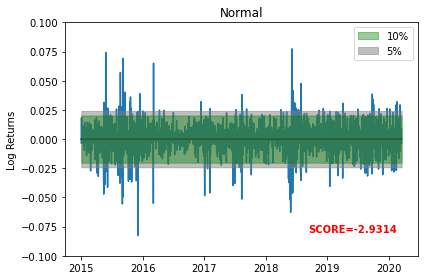

In [151]:
# first plot Normal
means = [i[0] for i in Val_Pred_Normal]
std   = [i[1] for i in Val_Pred_Normal]
x = pd.date_range("2015-01-01", periods=len(means),freq="D")


plt.plot(x,Nikkei['Data'].loc['2015-01-01':]['log_ret'][25:], color='#1f77b4',zorder=1)

ppf = scipy.stats.norm.ppf
SCORE = round(Normal_History.history["val_loss"][-1],4)
NAME = "Normal"
s1 = plt.fill_between(x,np.add(means,ppf(0.95,loc=means,scale=std)),np.add(means,ppf(0.05,loc=means,scale=std)), 
                      color='green',zorder=4,alpha=0.4)
s2 = plt.fill_between(x,np.add(means,ppf(0.975,loc=means,scale=std)),
                 np.add(means,ppf(0.025,loc=means,scale=std)), 
                 color='grey',
                     zorder=3,
                     alpha=0.5)
plt.plot(x,means, color='black',zorder=2)

plt.title(NAME)

plt.text(pd.to_datetime('2019-06-01'), 
        -0.08,
    "SCORE="+str(SCORE),
    horizontalalignment='center', 
        fontweight='bold', 
        color='red',
       fontsize='medium')

years = mdates.YearLocator(10)   # every year
years_fmt = mdates.DateFormatter('%Y')


#plt.xaxis.set_major_locator(years)
#plt.xaxis.set_major_formatter(years_fmt)
plt.ylabel("Log Returns")
plt.legend(handles=[s1,s2], labels=["10%","5%"],loc='upper right')
plt.ylim([-0.1, 0.1])
plt.tight_layout() 

plt.savefig('C:/Warwick Final Year/RAE/Graphs/Nikkei_Validation_' + NAME + '.pdf')

plt.show()

In [132]:
print(Val_Pred_t)

[[3.8836342e-07 8.7486599e-03 6.4382815e+00]
 [3.9364872e-07 8.6132530e-03 6.4257269e+00]
 [4.3088878e-07 8.0688810e-03 5.8846054e+00]
 ...
 [4.1168823e-07 7.5864503e-03 5.8210421e+00]
 [4.2686904e-07 7.4936999e-03 5.8072581e+00]
 [4.1221546e-07 6.9209258e-03 5.8236308e+00]]


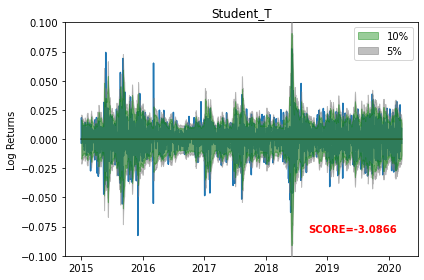

In [152]:
# Now t
means = [i[0] for i in Val_Pred_t]
scale   = [i[1] for i in Val_Pred_t]
dfs   = [i[2] for i in Val_Pred_t]
x = pd.date_range("2015-01-01", periods=len(means),freq="D")


plt.plot(x,Nikkei['Data'].loc['2015-01-01':]['log_ret'][25:], color='#1f77b4',zorder=1)

ppf = scipy.stats.t.ppf
         
SCORE = round(t_History.history["val_loss"][-1],4)
NAME = "Student_T"
         
s1 = plt.fill_between(x,np.add(means,ppf(0.95,df=dfs, loc=means,scale=scale)),
                      np.add(means,ppf(0.05,df=dfs,loc=means,scale=scale)), 
                      color='green',zorder=4,alpha=0.4)
s2 = plt.fill_between(x,np.add(means,ppf(0.975,df=dfs,loc=means,scale=scale)),
                 np.add(means,ppf(0.025,df=dfs,loc=means,scale=scale)), 
                 color='grey',
                     zorder=3,
                     alpha=0.5)
plt.plot(x,means, color='black',zorder=2)

plt.title(NAME)

plt.text(pd.to_datetime('2019-06-01'), 
        -0.08,
    "SCORE="+str(SCORE),
    horizontalalignment='center', 
        fontweight='bold', 
        color='red',
       fontsize='medium')

years = mdates.YearLocator(10)   # every year
years_fmt = mdates.DateFormatter('%Y')


#plt.xaxis.set_major_locator(years)
#plt.xaxis.set_major_formatter(years_fmt)
plt.ylabel("Log Returns")
plt.legend(handles=[s1,s2], labels=["10%","5%"],loc='upper right')
plt.ylim([-0.1, 0.1])
plt.tight_layout() 

plt.savefig('C:/Warwick Final Year/RAE/Graphs/Nikkei_Validation_' + 'Student_T' + '.pdf')

plt.show()

In [143]:
Val_Pred_Laplace

array([[0.0000000e+00, 1.2321919e-04],
       [0.0000000e+00, 1.1441381e-04],
       [0.0000000e+00, 1.0180033e-04],
       ...,
       [0.0000000e+00, 9.0018802e-05],
       [0.0000000e+00, 9.2526199e-05],
       [0.0000000e+00, 6.7817600e-05]], dtype=float32)

In [146]:
ppf(0.05,loc=0,scale=1.2e-4)

-0.00027631021115928547

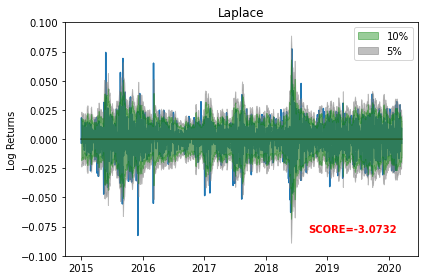

In [153]:
# Lastly the Laplacian
means = [i[0] for i in Val_Pred_Laplace]
scale   = [i[1] for i in Val_Pred_Laplace]
x = pd.date_range("2015-01-01", periods=len(means),freq="D")


plt.plot(x,Nikkei['Data'].loc['2015-01-01':]['log_ret'][25:], color='#1f77b4',zorder=1)

ppf = scipy.stats.laplace.ppf
         
SCORE = round(Laplace_History.history["val_loss"][-1],4)
NAME = "Laplace"
         
s1 = plt.fill_between(x,np.add(means,ppf(0.95,loc=means,scale=np.sqrt(np.divide(scale,2)))),
                      np.add(means,ppf(0.05,loc=means,scale=np.sqrt(np.divide(scale,2)))), 
                      color='green',zorder=4,alpha=0.4)
s2 = plt.fill_between(x,np.add(means,ppf(0.975,loc=means,scale=np.sqrt(np.divide(scale,2)))),
                 np.add(means,ppf(0.025,loc=means,scale=np.sqrt(np.divide(scale,2)))), 
                 color='grey',
                     zorder=3,
                     alpha=0.5)
plt.plot(x,means, color='black',zorder=2)

plt.title(NAME)

plt.text(pd.to_datetime('2019-06-01'), 
        -0.08,
    "SCORE="+str(SCORE),
    horizontalalignment='center', 
        fontweight='bold', 
        color='red',
       fontsize='medium')

years = mdates.YearLocator(10)   # every year
years_fmt = mdates.DateFormatter('%Y')


#plt.xaxis.set_major_locator(years)
#plt.xaxis.set_major_formatter(years_fmt)
plt.ylabel("Log Returns")
plt.legend(handles=[s1,s2], labels=["10%","5%"],loc='upper right')
plt.ylim([-0.1, 0.1])
plt.tight_layout() 

plt.savefig('C:/Warwick Final Year/RAE/Graphs/Nikkei_Validation_' + NAME + '.pdf')

plt.show()

# Creating the MCS (Hansen, Lunde, and Nasen ; 2011)

In [122]:
# first we get the validation losses for the three models

t_losses       = t_History.history["val_loss"][-1]
Normal_losses  = Normal_History.history["val_loss"][-1]
Laplace_losses = Laplace_History.history["val_loss"][-1]

In [ ]:

def gw(L: np.array,
       tau: int,
       H: Optional[np.array] = None,
       kernel: Optional[Union[str, Callable]] = None,
       bw: Optional[int] = None,
       kernel_kwargs: Optional[dict] = None,
       alpha: float = 0.05) -> tuple[float, float, float]:
    """
    Test of Equal Conditional Predictive Ability by Giacomini and White (2006).
    Used here for testing and debugging but made available through the package interface.
    This is a reimplementation from the MATLAB code provided by
    Giacomini (https://gist.github.com/ogrnz/91f37140011d1c2447934766274c4070)
    References:
        - Giacomini, R., & White, H. (2006). Tests of conditional predictive ability. Econometrica, 74(6), 1545-1578.
    :param L: (Tx2) array of forecast losses
    :param H: (Txq) array of instruments. If `None` provided, defaults to the unconditional EPA (DM test)
    :param tau: Forecast horizon
    :param kernel: (default `None`)
        If multistep forecast (`tau` > 1), covariance matrix is an HAC estimator.
        Original implementation uses a Bartlett kernel with bandwidth `tau - 1`.
        If a `str`, must match one of `arch` package variance estimator:
         > https://arch.readthedocs.io/en/latest/covariance/covariance.html
        If a `Callable`, must simply return a (qxq) covariance matrix (see arg `H`).
    :param bw: (default `None`)
        Bandwidth of the `kernel`. Typically set to `forecasting horizon - 1`.
        If set to `None`, will let the kernel compute the optimal bandwidth if supported.
    :param kernel_kwargs: (default `None`)
        An optional dict of `argument: value` passed to `kernel`.
        If `kernel` is a `Callable`, the eventual bandwidth must be passed here.
    :param alpha: Significance level
    :return: tuple(S, crit_val, p_val)
        S: test statistic,
        cval: critical value for significance lvl,
        pval: p-value of test
    """
    T = L.shape[0]  # Number of observations
    d = L[:, 0] - L[:, 1]  # Loss differential
    if H is None:  # Instruments (defaults to unconditional EPA)
        H = np.ones((T, 1))
    q = H.shape[1]

    reg = np.empty(H.shape)
    for jj in range(H.shape[1]):
        reg[:, jj] = H[:, jj] * d

    if tau == 1:  # One-step
        beta = np.linalg.lstsq(reg, np.ones(T), rcond=None)[0][0].item()
        res = np.ones(T) - beta * reg
        r2 = 1 - np.mean(res ** 2)
        S = T * r2
    else:  # Multistep
        omega = np.empty((q, q))  # Defined here to make linter happy and inform about dims
        if isinstance(kernel, Callable):  # Custom callable
            omega = kernel(reg, **kernel_kwargs)
        elif isinstance(kernel, str):  # Arch covariance
            kerfunc = getattr(kernels, kernel)
            ker = kerfunc(reg, bandwidth=bw, **kernel_kwargs)
            omega = ker.cov.long_run
        else:
            raise NotImplementedError
        zbar = reg.mean().T
        S = (T * zbar.T * np.linalg.pinv(omega) * zbar).item()

    dof = reg.shape[1]
    cval = chi2.ppf(1 - alpha, dof)
    pval = 1 - chi2.cdf(abs(S), dof)

    return S, cval, pval


def mgw(L: np.array,
        H: Optional = None,
        covar_style: Literal["sample", "hac"] = "sample",
        kernel: Optional[Union[str, Callable]] = None,
        bw: Optional[int] = None,
        kernel_kwargs: Optional[dict] = None,
        alpha: float = 0.05):
    """
    Implements the multivariate Giacomini-White (MGW) (Borup et al., 2022) test of equal predictive ability.
    This is a reimplementation from the MATLAB code provided by
    Borup (https://sites.google.com/view/danielborup/research)
    Notes:
        If only 2 models are compared, it reduces to the Giacomini-White test (GW) (Giacomini and White, 2006)
        If further no conditioning information H is given, it reduces to the
        original Diebold-Mariano test (DM) (Diebold and Mariano, 1995)
        If more than 2 models are compared but with no conditioning information H,
        it reduces to multivariate Diebold-Mariano (MDM) (Mariano and Preve, 2012)
    References:
        - Borup, Daniel and Eriksen, Jonas Nygaard and Kjær, Mads Markvart and Thyrsgaard, Martin,
        Predicting Bond Return Predictability. Available at http://dx.doi.org/10.2139/ssrn.3513340
        - Diebold, F.X., and R.S. Mariano (1995) ‘Comparing Predictive Accuracy,’ Journal
        of Business and Economic Statistics 13, 253–263.
        - Giacomini, R., & White, H. (2006). Tests of conditional predictive ability.
        Econometrica, 74(6), 1545-1578.
        - Mariano, R. S., & Preve, D. (2012). Statistical tests for multiple forecast comparison.
        Journal of econometrics, 169(1), 123-130.
    :param L:
        Txk matrix of losses of k models with T forecasts.
    :param H: (default `None`)
        Txq matrix of a constant and information set (test function).
        If not provided, set to a (Tx1) column vector of 1, amounts to the
        unconditional MWG test, which is equivalent to the multivariate Diebold-Mariano (Mariano and Preve, 2012).
    :param covar_style: (default 'sample')
        How to compute the covariance matrix.
        Either the sample covariance ('sample') or an HAC estimator ('hac').
    :param kernel: (default `None`)
        If covariance matrix is an HAC estimator, what type to compute.
        If a `str`, must match one of `arch` package variance estimator:
         > https://arch.readthedocs.io/en/latest/covariance/covariance.html
        If a `Callable`, must simply return a
    :param bw: (default `None`)
        Bandwidth of the `kernel`. Typically set to `forecasting horizon - 1`.
        If set to `None`, will let the kernel compute the optimal bandwidth if supported.
    :param kernel_kwargs: (default `None`)
        An optional dict of `argument: value` passed to `kernel`.
        If `kernel` is a `Callable`, the eventual bandwidth must be passed here.
    :param alpha: (default 0.05)
        Significance level.
    :return: tuple(S, cval, pval)
        S: float, the computed test statistic
        cval: float, the corresponding critical value
        pval: float, the p-value of S.
    """
    # Args checks
    if kernel is not None and covar_style == "sample":
        raise ValueError(f"{kernel=} incompatible with {covar_style=}.")
    if kernel is None and covar_style == "hac":
        raise ValueError("Set `kernel` when using an HAC estimator.")
    if bw is not None and covar_style == "sample":
        raise ValueError(f"{bw=} incompatible with {covar_style=}.")
    if L.shape[1] < 2:
        raise ValueError(f"Not enough columns for matrix of  losses {L.shape[1]=}.")

    if kernel_kwargs is None:
        kernel_kwargs = {}

    # Initialize
    T = L.shape[0]
    p = L.shape[1] - 1
    if H is None:  # defaults to unconditional EPA
        H = np.ones((T, 1))

    # Loss differentials
    D = np.diff(L, axis=1)

    # Conditioning information
    q = H.shape[1]
    reg = np.empty((T, q * p))

    for i in range(T):
        reg[i, :] = np.kron(H[i, :], D[i, :])

    Dbar = np.mean(reg, axis=0)

    # Compute covar matrix
    omega = np.empty((q * p, q * p))  # Defined here to make linter happy and inform about dims
    if covar_style == "sample":
        omega = (reg - Dbar).T @ (reg - Dbar) / (T - 1)
    elif covar_style == "hac":  # HAC estimator
        if isinstance(kernel, Callable):  # Custom callable
            omega = kernel(reg, **kernel_kwargs)
        elif isinstance(kernel, str):  # Arch covariance
            kerfunc = getattr(kernels, kernel)
            ker = kerfunc(reg, bandwidth=bw, **kernel_kwargs)
            omega = ker.cov.long_run
        else:
            raise NotImplementedError
    else:
        raise NotImplementedError

    # Compute statistic
    dof = q * p
    S = (T * Dbar @ np.linalg.pinv(omega) @ Dbar.T).item()
    cval = chi2.ppf(1 - alpha, dof)
    pval = 1 - chi2.cdf(S, dof)

    return S, cval, pval


def cmcs(L: np.array, H: Optional = None, alpha: float = 0.05, **kwargs):
    """
    Perform the Conditional Model Confidence Set (CMCS).
    The MCS procedure from Hansen (2011) is adapted to use MGW (Borup et al., 2022)
    instead of bootstrapping the critical values. Allows to reduce an initial set of models to a
    set of models with equal (conditional) predictive ability.
    Also, allows to use conditioning information (`H`, hence the 'Conditional'),
    to get the best MCS based on expected future loss.
    This is a reimplementation from the MATLAB code provided by
    Borup (https://sites.google.com/view/danielborup/research)
    References:
        - Borup, Daniel and Eriksen, Jonas Nygaard and Kjær, Mads Markvart and Thyrsgaard, Martin,
        Predicting Bond Return Predictability. Available at http://dx.doi.org/10.2139/ssrn.3513340
        - Hansen, P. R., Lunde, A., & Nason, J. M. (2011). The model confidence set. Econometrica, 79(2), 453-497.
    :param L:
        (Txk) matrix of losses of k models with T forecasts.
    :param H: (default `None`)
        (Txq) matrix of a constant and information set (test function).
        If not provided, set to a (Tx1) column vector of 1, amounts to the
        unconditional MWG test, which is equivalent to the multivariate Diebold-Mariano (Mariano and Preve, 2012).
    :param alpha: (default 0.05)
        Significance level used in the MGW test.
    :param **kwargs: Arguments passed to `feval.mgw`. Usually define covariance estimator and such.
    :return: tuple(mcs, S, cval, pval, removed)
        mcs: (1xk) np.array where models included in the best model confidence set are noted as 1.
        S: float, the computed test statistic of the last test.
        cval: float, the corresponding critical value.
        pval: float, the p-value of S.
        removed: (1xk) np.array where a column represents an algorithm cycle.
            That way, we can see which model index was removed at which iteration.
    """
    # Initialize
    T = L.shape[0]
    k = L.shape[1]
    if H is None:
        H = np.ones((T, 1))

    # Init loop
    S, cval, pval = np.inf, 1, 1
    mcs = np.ones((1, k))
    removed = np.zeros((1, k))

    j = 0
    while S > cval:
        # Create L_to_use, the losses of models still in MCS
        L_to_use = L[:, (mcs == 1)[0]]

        if L_to_use.shape[1] == 1:  # Only 1 model left in set
            break

        # Perform MGW
        S, cval, pval = mgw(L_to_use, H, alpha=alpha, **kwargs)

        # H0 still rejected, apply elimination criterion
        if S > cval:
            mcs, removed[0, j] = elim_rule(L, mcs, H)

        j += 1

    return mcs, S, cval, pval, removed


def elim_rule(L: np.array,
              mcs: np.array,
              H: Optional = None):
    """
    Elimination rule that allows to rank losses based on expected future loss given the information set `H`.
    If `H` is a vector of constant, it amounts to ranking losses based on average loss.
    See Borup et al. (2022) and Hansen (2011).
    This is a reimplementation from the MATLAB code provided by
    Borup (https://sites.google.com/view/danielborup/research)
    References:
        - Borup, Daniel and Eriksen, Jonas Nygaard and Kjær, Mads Markvart and Thyrsgaard, Martin,
        Predicting Bond Return Predictability. Available at http://dx.doi.org/10.2139/ssrn.3513340
        - Hansen, P. R., Lunde, A., & Nason, J. M. (2011). The model confidence set. Econometrica, 79(2), 453-497.
    :param L:
        (Txk) matrix of losses of k models with T forecasts.
    :param mcs:
        (1xk) vector of current model confidence set, where the least performing model will be eliminated.
    :param H: (default `None`)
        (Txq) matrix of a constant and information set (test function).
    :return: tuple(mcs, removed)
        mcs: (1xk) np.array where models included in the best model confidence set are noted as 1.
        removed: (1xk) np.array where a column represents an algorithm cycle.
            That way, we can see which model index was removed at which iteration.
    """
    # Initialize
    k = mcs.shape[1]
    q = H.shape[1]
    new_k = np.count_nonzero(mcs)

    if L.shape[1] != k:
        raise ValueError(f"Dimensions of {L.shape[1]=} do not match {mcs.shape[1]=}.")

    L_to_use = np.zeros((L.shape[0], new_k))
    curr_set = np.zeros((1, new_k))
    j = 0
    for i in range(k):  # TODO could be simplified?
        if mcs[0, i] == 1:
            L_to_use[:, j] = L[:, i]
            curr_set[0, j] = i
            j += 1

    combinations = np.arange(0, j).reshape(1, -1)  # TODO why matrix? could be vect
    L_hat = np.zeros(combinations.shape)

    # Estimate
    for j in range(combinations.shape[0]):  # TODO no loop if vect
        L_intra_use = L_to_use[:, combinations[j, :]]  # TODO directly call j?

        deltas = np.zeros((q, new_k - 1))
        for i in range(L_to_use.shape[1] - 1):
            Y_used = L_intra_use[:, i + 1] - L_intra_use[:, i]
            Y_used = Y_used.reshape(-1, 1)
            deltas[:, i] = (np.linalg.inv(H.T @ H) @ H.T @ Y_used).reshape(-1, )

        delta_L_hat = (deltas.T @ H[-1, :].T).reshape(-1, 1)
        starting_point = combinations[combinations == 0]  # should always return 1 idx

        # Normalize
        vL_hat = np.zeros(L_hat.shape)
        vL_hat[0, 0] = 1
        for i in range(L_to_use.shape[1] - 1):
            vL_hat[0, i + 1] = vL_hat[0, i] + delta_L_hat[i, 0]
        L_hat[j, :] = np.divide(vL_hat, vL_hat[0, starting_point].item())

    # Rank losses
    indx = np.argmax(L_hat)
    col = np.unique(combinations[0, indx])

    # Update mcs
    mcs[0, curr_set[0, col].astype(int)] = 0
    removed = curr_set[0, col]
    return mcs, removed